# 风格迁移

In [1]:
import torch
from torch import nn
import d2l.torch as d2l
import torchvision

In [2]:
content_img = d2l.Image.open('img/tmp.jpg')
style_img = d2l.Image.open('img/if.jpg')

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
    #    torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [4]:
pertrained_net = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1)

In [5]:
style_layer, content_layer = [0, 5, 10, 19, 28], [25]

In [6]:
net = nn.Sequential(*[pertrained_net.features[i] for i in range(max(content_layer + style_layer) + 1)])

In [7]:
def extract_features(X, content_layer, style_layer):
    contents = []
    style = []
    for i in range(len(net)):
        X = net[i](X)
        for i in style_layer:
            style.append(X)
        for i in content_layer:
            contents.append(X)
    return contents, style

In [8]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layer, style_layer)
    return content_X, contents_Y
    
def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layer, style_layer)
    return style_X, styles_Y

In [9]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

In [10]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [11]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [12]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [13]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [14]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [15]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [16]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layer, style_layer)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X

In [17]:
shape_img = torchvision.io.read_image('img/tmp.jpg')
shape = (shape_img.shape[1], shape_img.shape[2])
shape

(6000, 8000)

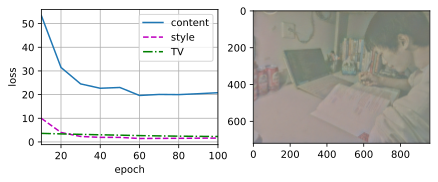

In [18]:
device, image_shape = d2l.try_gpu(), (720, 960)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 100, 50)

In [19]:
torchvision.utils.save_image(output, 'temp.jpg')